In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

c:\Users\ammar\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\ammar\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\ammar\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [37]:
from torchvision import datasets, transforms
import matplotlib.pyplot as plt # for plotting
import numpy as np
import torch
import math
import os

class_names = {
    0: 'A',
    1: 'B',
    2: 'C',
    3: 'D',
    4: 'E',
    5: 'F',
    6: 'G',
    7: 'H',
    8: 'I'
}

transform = transforms.Compose([
            # transforms.RandomHorizontalFlip(), # Flip the data horizontally
            transforms.ToPILImage(),
            transforms.Resize((128, 128)),
            transforms.RandomAdjustSharpness(0.25),
            transforms.RandomHorizontalFlip(0.5),
            transforms.RandomVerticalFlip(0.5),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
        ])

# Load the data with all of the classes
root = 'data/birds1/'
data_dirs = os.listdir(root)
data_dirs = np.array(data_dirs)
data_dirs = data_dirs.flatten()

roots = np.array([root] * len(data_dirs))
data_dirs = np.core.defchararray.add(roots, data_dirs)

# data_list = np.array(data.imgs)

# Get the indices for the train/val/test split of 75/15/15
train_split = math.floor(0.9 * len(data_dirs))
val_split = math.ceil(0.05 * len(data_dirs))
test_split = val_split

# print(train_split + val_split + test_split, len(data_arr))

# Make sure the splits are correct
assert train_split + val_split + test_split == len(data_dirs)

# Split the dataset randomely
generator = torch.Generator().manual_seed(1)
train, val, test = torch.utils.data.random_split(data_dirs, [train_split, val_split, test_split], generator=generator)

len(train), len(val), len(test)


(3202, 178, 178)

In [30]:
data_dirs

array(['data/birds1/frame_0124.jpg', 'data/birds1/frame_0125.jpg',
       'data/birds1/frame_0126.jpg', ..., 'data/birds1/frame_6254.jpg',
       'data/birds1/frame_6255.jpg', 'data/birds1/frame_6257.jpg'],
      dtype='<U26')

In [4]:
import cv2

class GenData(torch.utils.data.Dataset):
    '''
        Data set class to store the feature maps
    
    '''

    def __init__(self, in_data, transform=None):
        # data = np.array(in_data)
        self.input_dirs = in_data
        # self.labels = data[:, 1]
        self.labels = []
        self.input_transform = transform[0]
        self.transform = transform[1]
        self.resize_transform = transforms.Compose([
                                    transforms.ToPILImage(),
                                    transforms.Resize(128)
                                ])


    def __len__(self):
        return len(self.input_dirs)
    
    def __getitem__(self, idx):
        input_dir = self.input_dirs[idx]

        # Load the data
        inputs = cv2.imread(input_dir)
        inputs = cv2.cvtColor(inputs, cv2.COLOR_BGR2RGB)
        # inputs = inputs.swapaxes(0, 2)

        # labels = (int)(self.labels[idx])

        if self.transform:
            inputs = self.input_transform(inputs)
            transformed = self.transform(inputs)

            # labels = self.input_transform(labels)

            return inputs, transformed, inputs
        else:
            return inputs, inputs, inputs

In [31]:
# Create data loaders
def get_data_loaders(batch_size=1):
    
    train_data = GenData(data_dirs[train.indices], transform=(transform, transform))
    val_data = GenData(data_dirs[val.indices], transform=(transform, transform))
    test_data = GenData(data_dirs[test.indices], transform=(transform, transform))

    train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
    val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
    test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

    return train_dataloader, val_dataloader, test_dataloader



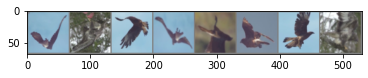

In [32]:
'''Code to visualize the data in the training set'''

import torchvision


def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
# Get a batch of training data
train_dataloader, _, _ = get_data_loaders(8)
inputs, _, _ = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
# imshow(out, title=[class_names[x.item()] for x in classes])
imshow(out)

In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim



class VAENet(nn.Module):
    def __init__(self, name="BirdNet", transfer_model=None, transfer_ftrs=64):
        super(VAENet, self).__init__()

        self.name = name
        self.transfer_model = transfer_model
        self.transfer_ftrs = transfer_ftrs

        self.latent_dim = 100

        self.front = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=3), # 224 --> 72 = (224 + 0 - 11)/3 + 1
            nn.MaxPool2d(kernel_size=3, stride=3), # 72 --> 24 = (72 + 0 - 3)/3 + 1
            nn.ReLU(),
            nn.BatchNorm2d(96),

            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=3, padding=1, stride=1), # 24 --> 24 = (24 + 2 - 3)/1 + 1
            nn.MaxPool2d(kernel_size=4, stride=2), # 24 --> 11 (24 + 6 - 3)/3 + 1
            nn.ReLU(),
            nn.BatchNorm2d(256),

            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1, stride=1), # 11 --> 11 = (11 + 2 - 3)/1 + 1
            nn.ReLU(),
            nn.BatchNorm2d(384),

            # nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1, stride=1), # 11 --> 11 = (11 + 2 - 3)/1 + 1
            # nn.ReLU(),
            # nn.BatchNorm2d(384),

            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1), # 11 --> 11 = (10 + 2 - 3)/1 + 1
            nn.MaxPool2d(kernel_size=3, stride=2), # 11 --> 5 = (11 + 0 - 3)/2 + 1
            nn.ReLU(),
            nn.BatchNorm2d(256),

        )

        self.muFC = nn.Linear(5 * 5 * 256, self.latent_dim)
        self.logvarFC = nn.Linear(5 * 5 * 256, self.latent_dim)

        self.transfer_muFC = nn.Linear(self.transfer_ftrs, self.latent_dim)
        self.transfer_logvarFC = nn.Linear(self.transfer_ftrs, self.latent_dim)

        self.latentFC = nn.Linear(self.latent_dim, 5 * 5 * 256)

        self.back = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=384, kernel_size=3, stride=2, padding=0, output_padding=0), # 5 -> 11
            nn.ReLU(),
            nn.BatchNorm2d(384),

            nn.ConvTranspose2d(in_channels=384, out_channels=256, kernel_size=3, padding=0, stride=2, output_padding=1), # 11 -> 24
            nn.ReLU(),
            nn.BatchNorm2d(256),

            nn.ConvTranspose2d(in_channels=256, out_channels=96, kernel_size=3, padding=0, stride=3, output_padding=0), # 24 -> 72
            nn.ReLU(),
            nn.BatchNorm2d(96),

            nn.ConvTranspose2d(in_channels=96, out_channels=3, kernel_size=11, padding=0, stride=3, output_padding=0), # 72 -> 224
            # nn.ReLU()
        )

    def encoder(self, x):

        mu, logvar = None, None

        if not self.transfer_model:
            x = self.front(x)
            x = x.view(-1, 5 * 5 * 256)

            mu = self.muFC(x)
            logvar = self.logvarFC(x)

        else:
            x = self.transfer_model(x)
            x = x.view(-1, self.transfer_ftrs)

            mu = self.transfer_muFC(x)
            logvar = self.transfer_logvarFC(x)

        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = std.data.new(std.size()).normal_()
        return eps.mul(std).add_(mu)
    
    def decoder (self, x):
        x = self.latentFC(x)
        x = x.view(-1, 256, 5, 5)

        x = self.back(x)
        x = F.softmax(x, 0)

        return x

    def forward(self, x):
        # x = self.forward_pass(x)
        # x = x.squeeze(1)
        # x = F.softmax(x, dim=1)

        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        y = self.decoder(z)
        
        return y, z, mu, logvar

In [8]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim



class VAENetSmall(nn.Module):
    def __init__(self, name="BirdNet", transfer_model=None, transfer_ftrs=64):
        super(VAENetSmall, self).__init__()

        self.name = name
        self.transfer_model = transfer_model
        self.transfer_ftrs = transfer_ftrs

        self.latent_dim = 256

        self.front = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=36, kernel_size=11, stride=3), # 224 --> 40 = (128 + 0 - 11)/3 + 1
            # nn.MaxPool2d(kernel_size=3, stride=3), # 72 --> 24 = (72 + 0 - 3)/3 + 1
            nn.ReLU(),
            nn.BatchNorm2d(36),
            nn.Dropout(0.5),

            nn.Conv2d(in_channels=36, out_channels=64, kernel_size=3, padding=1, stride=2), # 40 --> 20 = (40 + 2 - 3)/2 + 1
            # nn.MaxPool2d(kernel_size=4, stride=2), # 24 --> 11 (24 + 6 - 3)/3 + 1
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(0.5),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=2), # 20 --> 10 = (20 + 2 - 3)/2 + 1
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(0.5),

            # nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1, stride=1), # 11 --> 11 = (11 + 2 - 3)/1 + 1
            # nn.ReLU(),
            # nn.BatchNorm2d(384),

            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1, stride=2), # 10 --> 5 = (10 + 2 - 3)/1 + 1
            # nn.MaxPool2d(kernel_size=3, stride=2), # 11 --> 5 = (11 + 0 - 3)/2 + 1
            nn.ReLU(),
            nn.BatchNorm2d(64),

        )

        self.muFC = nn.Linear(5 * 5 * 64, self.latent_dim)
        self.logvarFC = nn.Linear(5 * 5 * 64, self.latent_dim)

        self.transfer_muFC = nn.Linear(self.transfer_ftrs, self.latent_dim)
        self.transfer_logvarFC = nn.Linear(self.transfer_ftrs, self.latent_dim)

        self.latentFC = nn.Linear(self.latent_dim, 5 * 5 * 64)

        self.back = nn.Sequential(
            #nn.ConvTranspose2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=0, output_padding=0), # 5 -> 11
            nn.ConvTranspose2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1), # 5 -> 10
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(0.5),

            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, padding=1, stride=2, output_padding=1), # 10 -> 20
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(0.5),

            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, padding=1, stride=2, output_padding=1), # 20 -> 40
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.5),

            nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=11, padding=0, stride=3, output_padding=0), # 40 -> 128
            # nn.ReLU()
        )

    def encoder(self, x):

        mu, logvar = None, None

        if not self.transfer_model:
            x = self.front(x)
            x = x.view(-1, 5 * 5 * 64)

            mu = self.muFC(x)
            logvar = self.logvarFC(x)

        else:
            x = self.transfer_model(x)
            x = x.view(-1, self.transfer_ftrs)

            mu = self.transfer_muFC(x)
            logvar = self.transfer_logvarFC(x)

        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = std.data.new(std.size()).normal_()
        return eps.mul(std).add_(mu)
    
    def decoder (self, x):
        x = self.latentFC(x)
        x = x.view(-1, 64, 5, 5)

        x = self.back(x)
        x = F.softmax(x)

        return x

    def forward(self, x):
        # x = self.forward_pass(x)
        # x = x.squeeze(1)
        # x = F.softmax(x, dim=1)

        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        y = self.decoder(z)
        
        return y, z, mu, logvar

In [137]:
from torchsummary import summary

model = VAENetSmall()
model.to('cuda:0')

summary(model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 36, 40, 40]          13,104
              ReLU-2           [-1, 36, 40, 40]               0
       BatchNorm2d-3           [-1, 36, 40, 40]              72
           Dropout-4           [-1, 36, 40, 40]               0
            Conv2d-5           [-1, 64, 20, 20]          20,800
              ReLU-6           [-1, 64, 20, 20]               0
       BatchNorm2d-7           [-1, 64, 20, 20]             128
           Dropout-8           [-1, 64, 20, 20]               0
            Conv2d-9          [-1, 128, 10, 10]          73,856
             ReLU-10          [-1, 128, 10, 10]               0
      BatchNorm2d-11          [-1, 128, 10, 10]             256
          Dropout-12          [-1, 128, 10, 10]               0
           Conv2d-13             [-1, 64, 5, 5]          73,792
             ReLU-14             [-1, 6

C:\Users\ammar\AppData\Local\Temp\ipykernel_25564\2234998305.py:105: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


In [9]:
'''
Loss function
'''

def vaekl_loss(recon_x, x, mu, logvar, batch_size):
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    kld /= batch_size * 3 * 128 * 128
    return kld

In [10]:
'''
Helper functions (based off of previous labs)
'''

def calculate_error(inputs, target):
    difference = torch.abs(target - inputs)
    mean_error = torch.mean(difference, dim=-1) # mean along width
    mean_error = torch.mean(mean_error, dim=-1) # mean along height
    mean_error = torch.mean(mean_error, dim=-1) # mean along channel

    # print(difference.size())
    # print(mean_error.size())
    # print(mean_error)

    return mean_error.sum()  


def evaluate(model, loader, criterion, cuda=False, batch_size=64, alex=False):
    '''
    Function to evaluate the model's performance on a val/test set
    '''


    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, transformed, labels = data

        ########## SENDING TO CUDA ############
        if cuda:
            inputs = inputs.to('cuda:0')
            transformed = transformed.to('cuda:0')
            
        

        outputs, latent_vector, mu, logvar = model(transformed)

        if alex:
            labels = labels.squeeze(1)

        # loss = 200 * criterion(outputs, inputs.float()) + 200 * vaekl_loss(outputs, inputs, mu, logvar, batch_size)
        loss =  model.loss_function(outputs, inputs, mu, logvar, M_N=10)['loss']


        # Find the mean error over the image
        output_err = calculate_error(outputs, inputs) 

        total_err += output_err
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss


def get_model_name(name, batch_size, learning_rate, momentum, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_m{3}_epoch{4}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   momentum,
                                                   epoch)
    return path


# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()


In [11]:
'''
Train Loop
'''

import tqdm
import time
from torch.optim import lr_scheduler

OUTPUT_DIR = 'runs/'

def train_network(model, batch_size=32, lr=0.005, momentum=0.9, num_epochs=30, cuda=True, loader=None, alex=False, sheduler=False):

    # Set manual seed for reproducible results
    torch.manual_seed(1)

    # Get the dataloaders with respective batch size
    train_dl, val_dl, _ = get_data_loaders(batch_size=batch_size)

    # Criterion and optimizer
    criterion = nn.MSELoss()
    # optimizer =  optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    optimizer =  optim.Adam(model.parameters(), lr=lr, weight_decay=1e-3)

    if sheduler:
        exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)



    # Training metrics
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)

    best_train_err = 1000
    best_val_err = 1000

    ########## SENDING TO CUDA ############
    if cuda:
        model = model.to('cuda:0')

    start_time = time.time()
    model.train()

    # Train loop
    for epoch in tqdm.tqdm(range(num_epochs)):
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0

        for i, data in enumerate(train_dl if not loader else loader):

            inputs, transformed, labels = data


            ########## SENDING TO CUDA ############
            if cuda:
                inputs = inputs.to('cuda:0')
                transformed = transformed.to('cuda:0')

            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs, latent_vector, mu, logvar = model(transformed)

            if alex:
                labels = labels.squeeze(1)

            # loss = 200 * criterion(outputs, inputs.float()) + 200 * vaekl_loss(outputs, inputs, mu, logvar, batch_size)
            loss =  model.loss_function(outputs, inputs, mu, logvar, M_N=10)['loss']
            loss.backward()
            optimizer.step()

            # Find the mean error over the image
            output_err = calculate_error(outputs, inputs)

            total_train_err += output_err
            total_train_loss += loss.item()
            total_epoch += len(labels)

        if sheduler:
            exp_lr_scheduler.step()

        train_err[epoch] = float(total_train_err) / (total_epoch)
        train_loss[epoch] = float(total_train_loss) / (i + 1)
        val_err[epoch], val_loss[epoch] = evaluate(model, val_dl if not loader else loader, criterion, cuda, batch_size, alex)

        tqdm.tqdm.write(f'Epoch {epoch}: Train err: {train_err[epoch]}, Train loss: {train_loss[epoch]} | Validation err: {val_err[epoch]}, Validation loss: {val_loss[epoch]}')

        # Check whether a better train/val err has been found
        better = False
        if train_err[epoch] < best_train_err:
            best_train_err = train_err[epoch]
            better = True
        if val_err[epoch] < best_val_err:
            best_val_err = val_err[epoch]
            better = True

        if better or epoch == (num_epochs - 1):
            model_path = OUTPUT_DIR + get_model_name(model.name, batch_size, lr, momentum, epoch)

            torch.save(model.state_dict(), model_path)

    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)



In [12]:
from torchvision import models


model_ft = models.resnet18(pretrained=True) # IMAGENET1K_V1
model_ft.name = 'resent_small'
count = 0
for param in model_ft.parameters():
    # if count > 30:
    #     break
    param.requires_grad = False
    count += 1

print(count)
num_ftrs = model_ft.fc.in_features

62


In [21]:
from typing import List, Callable, Union, Any, TypeVar, Tuple
# from torch import tensor as Tensor

Tensor = TypeVar('torch.tensor')

from torch import nn
from abc import abstractmethod

class BaseVAE(nn.Module):
    
    def __init__(self) -> None:
        super(BaseVAE, self).__init__()

    def encode(self, input: Tensor) -> List[Tensor]:
        raise NotImplementedError

    def decode(self, input: Tensor) -> Any:
        raise NotImplementedError

    def sample(self, batch_size:int, current_device: int, **kwargs) -> Tensor:
        raise NotImplementedError

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        raise NotImplementedError

    @abstractmethod
    def forward(self, *inputs: Tensor) -> Tensor:
        pass

    @abstractmethod
    def loss_function(self, *inputs: Any, **kwargs) -> Tensor:
        pass

import torch
# from models import BaseVAE
from torch import nn
from torch.nn import functional as F
# from .types_ import *


class VanillaVAE(BaseVAE):


    def __init__(self,
                 in_channels: int,
                 latent_dim: int,
                 hidden_dims: List = None,
                 **kwargs) -> None:
        super(VanillaVAE, self).__init__()

        self.latent_dim = latent_dim

        self.encoder_modules = []
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512]

        # Build Encoder
        for h_dim in hidden_dims:
            self.encoder_modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU(),
                    nn.Dropout(0.3))
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*self.encoder_modules)
        self.fc_mu = nn.Linear(hidden_dims[-1]*16, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1]*16, latent_dim)


        # Build Decoder
        self.decoder_modules = []

        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * 16)

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            self.decoder_modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU(),
                    nn.Dropout(0.3))
            )



        self.decoder = nn.Sequential(*self.decoder_modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels= 3,
                                      kernel_size= 3, padding= 1),
                            nn.Sigmoid())

    def encode(self, input: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

    def decode(self, z: Tensor) -> Tensor:
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        result = self.decoder_input(z)
        result = result.view(-1, 256, 4, 4)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result
    
    def autoencoder(self, x) -> Tensor:
        # x = self.encoder(x) # x is (B, 512, 4, 4)
        # x = self.decoder(x)

        skip_connections = []

        for module in self.encoder_modules:
            x = module(x)
            skip_connections.append(x)

        # for connection in skip_connections:
        #     print(connection.size())

        skip_connections.reverse()
        count = 1

        for module in self.decoder_modules:
            x = module(x) + 0.01 * skip_connections[count]
            count+= 1


        x = self.final_layer(x)

        return x


    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input: Tensor, **kwargs) -> List[Tensor]:
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return  [self.decode(z), input, mu, log_var]

        # return [self.autoencoder(input), _, _, _]

    def loss_function(self,
                      *args,
                      **kwargs) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]
        # print(recons.size(), input.size())

        kld_weight = kwargs['M_N'] # Account for the minibatch samples from the dataset
        recons_loss = F.mse_loss(recons, input)


        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        loss = 100 * recons_loss + kld_weight * kld_loss
        # loss = recons_loss 

        # return {'loss': loss}

        return {'loss': loss, 'Reconstruction_Loss':recons_loss.detach(), 'KLD':-kld_loss.detach()}

    def sample(self,
               num_samples:int,
               current_device: int, **kwargs) -> Tensor:
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples,
                        self.latent_dim)

        z = z.to(current_device)

        samples = self.decode(z)
        return samples

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward(x)[0]

In [22]:
from torchsummary import summary

model = VanillaVAE(3, 256, [32, 64, 128, 256])
model.to('cuda:0')

summary(model, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
         LeakyReLU-3           [-1, 32, 32, 32]               0
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 16, 16]          18,496
       BatchNorm2d-6           [-1, 64, 16, 16]             128
         LeakyReLU-7           [-1, 64, 16, 16]               0
           Dropout-8           [-1, 64, 16, 16]               0
            Conv2d-9            [-1, 128, 8, 8]          73,856
      BatchNorm2d-10            [-1, 128, 8, 8]             256
        LeakyReLU-11            [-1, 128, 8, 8]               0
          Dropout-12            [-1, 128, 8, 8]               0
           Conv2d-13            [-1, 256, 4, 4]         295,168
      BatchNorm2d-14            [-1, 25

In [23]:
'''
More epochs
'''
# net = VAENetSmall("ASL_small", transfer_model=None, transfer_ftrs=1000)
net = VanillaVAE(3, 256, [32, 64, 128, 256])
net.name = "birdgen"


batch = 64
lr = 0.001
m = 0.9
epochs = 50

train_network(net, batch_size=batch, lr=lr, momentum=m, num_epochs=epochs, cuda=True)
model_path =  OUTPUT_DIR + get_model_name(net.name, batch, lr, m, epochs-1)
plot_training_curve(model_path)

  2%|▏         | 1/50 [00:15<12:52, 15.77s/it]

Epoch 0: Train err: 0.340508122059943, Train loss: 230.34302438474168 | Validation err: 0.307212465264824, Validation loss: 38.777975718180336


  4%|▍         | 2/50 [00:31<12:25, 15.52s/it]

Epoch 1: Train err: 0.31327876055858644, Train loss: 36.39630687938017 | Validation err: 0.30548217859161036, Validation loss: 51.06235376993815


  6%|▌         | 3/50 [00:46<12:15, 15.65s/it]

Epoch 2: Train err: 0.3126051626973864, Train loss: 41.473620994418276 | Validation err: 0.3063473219282172, Validation loss: 56.0552864074707


  8%|▊         | 4/50 [01:02<11:51, 15.48s/it]

Epoch 3: Train err: 0.312447332874229, Train loss: 39.387497284833124 | Validation err: 0.3068090931753094, Validation loss: 28.598347345987957


 10%|█         | 5/50 [01:17<11:34, 15.43s/it]

Epoch 4: Train err: 0.3121411849527639, Train loss: 27.608260547413547 | Validation err: 0.306576632381825, Validation loss: 31.16075325012207


 12%|█▏        | 6/50 [01:32<11:19, 15.43s/it]

Epoch 5: Train err: 0.31199685072318084, Train loss: 26.69475933149749 | Validation err: 0.3055049167590195, Validation loss: 22.92437807718913


 14%|█▍        | 7/50 [01:48<11:07, 15.53s/it]

Epoch 6: Train err: 0.3117662628764737, Train loss: 23.171014299579696 | Validation err: 0.3045913396256693, Validation loss: 20.94850476582845


 16%|█▌        | 8/50 [02:04<10:52, 15.53s/it]

Epoch 7: Train err: 0.31165683038677, Train loss: 21.565556395287608 | Validation err: 0.30591131060310967, Validation loss: 18.24432881673177


 18%|█▊        | 9/50 [02:20<10:40, 15.63s/it]

Epoch 8: Train err: 0.31162774242660835, Train loss: 18.47698705336627 | Validation err: 0.30515520760182585, Validation loss: 16.554630597432453


 20%|██        | 10/50 [02:35<10:21, 15.54s/it]

Epoch 9: Train err: 0.3115155841319878, Train loss: 17.400355488646266 | Validation err: 0.3050673409794154, Validation loss: 16.358851432800293


 22%|██▏       | 11/50 [02:51<10:13, 15.72s/it]

Epoch 10: Train err: 0.3114088393240553, Train loss: 18.22541986727247 | Validation err: 0.3054240794664019, Validation loss: 15.749059041341146


 24%|██▍       | 12/50 [03:07<09:56, 15.69s/it]

Epoch 11: Train err: 0.31143512523300865, Train loss: 17.017738080492208 | Validation err: 0.3042993652686644, Validation loss: 14.603179295857748


 26%|██▌       | 13/50 [03:22<09:38, 15.62s/it]

Epoch 12: Train err: 0.31119067962284314, Train loss: 16.110090349234788 | Validation err: 0.3050206859460038, Validation loss: 14.553762753804525


 28%|██▊       | 14/50 [03:37<09:17, 15.48s/it]

Epoch 13: Train err: 0.3111786136472322, Train loss: 15.948541155048446 | Validation err: 0.30518488937549376, Validation loss: 14.101389567057291


 30%|███       | 15/50 [03:54<09:10, 15.74s/it]

Epoch 14: Train err: 0.3113825152919562, Train loss: 16.12376544054817 | Validation err: 0.3047658941718969, Validation loss: 14.18896516164144


 32%|███▏      | 16/50 [04:10<08:57, 15.80s/it]

Epoch 15: Train err: 0.3110568864430434, Train loss: 16.132345629673377 | Validation err: 0.3050417953662658, Validation loss: 13.917608261108398


 32%|███▏      | 16/50 [04:14<09:01, 15.92s/it]


KeyboardInterrupt: 

In [39]:
class CVAE(nn.Module):
    def __init__(self, latent_dim):
        super(CVAE, self).__init__()

        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
        )

        self.fc_mu = nn.Linear(256 * 8 * 8, latent_dim)
        self.fc_logvar = nn.Linear(256 * 8 * 8, latent_dim)

        # Decoder
        self.decoder_input = nn.Linear(latent_dim, 256 * 8 * 8)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        x = torch.flatten(x, start_dim=1)

        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        return mu, logvar

    def decode(self, z):
        x = self.decoder_input(z)
        x = x.view(-1, 256, 8, 8)
        x = self.decoder(x)
        return x

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        reconstruction = self.decode(z)
        return reconstruction, x, mu, logvar

    def generate(self, z):
        generated = self.decode(z)
        return generated

    def interpolate(self, z1, z2, num_steps):
        assert z1.size() == z2.size(), "Latent vectors must have the same size."

        interpolation = torch.zeros(num_steps+2, z1.size(1)).to(z1.device)
        interpolation[0] = z1
        interpolation[-1] = z2

        for i in range(1, num_steps+1):
            alpha = i / (num_steps + 1)
            interpolation[i] = alpha * z2 + (1 - alpha) * z1

        generated = self.generate(interpolation)
        return generated

    def loss_function(self, recon_x, x, mu, logvar, M_N):
        reconstruction_loss = F.mse_loss(recon_x, x, reduction='sum')
        kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return {'loss': reconstruction_loss + M_N * kld_loss}


In [23]:
from torchsummary import summary

model = CVAE(128)
model.to('cuda:0')

summary(model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]           1,568
              ReLU-2           [-1, 32, 64, 64]               0
            Conv2d-3           [-1, 64, 32, 32]          32,832
              ReLU-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 16, 16]         131,200
              ReLU-6          [-1, 128, 16, 16]               0
            Conv2d-7            [-1, 256, 8, 8]         524,544
              ReLU-8            [-1, 256, 8, 8]               0
            Linear-9                  [-1, 128]       2,097,280
           Linear-10                  [-1, 128]       2,097,280
           Linear-11                [-1, 16384]       2,113,536
  ConvTranspose2d-12          [-1, 128, 16, 16]         524,416
             ReLU-13          [-1, 128, 16, 16]               0
  ConvTranspose2d-14           [-1, 64,

  1%|          | 1/100 [00:53<1:28:22, 53.56s/it]

Epoch 0: Train err: 0.37392992142362197, Train loss: 10617.166954369339 | Validation err: 0.29974187358041826, Validation loss: 7543.7991943359375


  2%|▏         | 2/100 [01:46<1:27:12, 53.40s/it]

Epoch 1: Train err: 0.28674712886965176, Train loss: 7598.192071689508 | Validation err: 0.27401913417859025, Validation loss: 6661.053256945664


  3%|▎         | 3/100 [02:40<1:26:09, 53.29s/it]

Epoch 2: Train err: 0.27348685041209597, Train loss: 6804.727682329281 | Validation err: 0.27120900957771904, Validation loss: 6735.404775555214


  4%|▍         | 4/100 [03:32<1:25:01, 53.14s/it]

Epoch 3: Train err: 0.27102295150613875, Train loss: 6759.049882229979 | Validation err: 0.26679752649885885, Validation loss: 6330.33729124605


  5%|▌         | 5/100 [04:33<1:28:20, 55.79s/it]

Epoch 4: Train err: 0.26977125426369264, Train loss: 31028.186907108837 | Validation err: 0.26900582902886894, Validation loss: 6655.073318995786


  6%|▌         | 6/100 [05:26<1:25:59, 54.89s/it]

Epoch 5: Train err: 0.2681384780569273, Train loss: 6690.187316322684 | Validation err: 0.268058412530449, Validation loss: 6618.646517292837


  7%|▋         | 7/100 [06:19<1:24:03, 54.23s/it]

Epoch 6: Train err: 0.2663300685179673, Train loss: 6808.174901291552 | Validation err: 0.2630247051796217, Validation loss: 6634.88393170646


  8%|▊         | 8/100 [07:12<1:22:34, 53.85s/it]

Epoch 7: Train err: 0.2658972945680922, Train loss: 6798.816254291141 | Validation err: 0.2615157995331153, Validation loss: 6451.1046142578125


  9%|▉         | 9/100 [08:06<1:21:56, 54.03s/it]

Epoch 8: Train err: 0.26438559747203894, Train loss: 6598.2287878242605 | Validation err: 0.26283810647685873, Validation loss: 6534.942517227001


 10%|█         | 10/100 [09:03<1:22:08, 54.76s/it]

Epoch 9: Train err: 0.2644341854212211, Train loss: 6551.195161456097 | Validation err: 0.26356454913535815, Validation loss: 6715.297836475158


 11%|█         | 11/100 [10:02<1:23:25, 56.24s/it]

Epoch 10: Train err: 0.2636916037278947, Train loss: 6794.944182339346 | Validation err: 0.25995404532786165, Validation loss: 6263.20991704705


 12%|█▏        | 12/100 [10:58<1:22:14, 56.07s/it]

Epoch 11: Train err: 0.2617720461576749, Train loss: 6328.614944448477 | Validation err: 0.2603771338302098, Validation loss: 6251.687294263518


 13%|█▎        | 13/100 [11:52<1:20:22, 55.43s/it]

Epoch 12: Train err: 0.2617563584832234, Train loss: 6434.212074751559 | Validation err: 0.2595350072624978, Validation loss: 6277.916642435481


 14%|█▍        | 14/100 [12:45<1:18:28, 54.75s/it]

Epoch 13: Train err: 0.26161427351923605, Train loss: 6413.022840377169 | Validation err: 0.260169682877787, Validation loss: 6404.693912120348


 15%|█▌        | 15/100 [13:39<1:16:56, 54.31s/it]

Epoch 14: Train err: 0.26128589980383354, Train loss: 6299.886298022964 | Validation err: 0.2614422487408927, Validation loss: 6420.594616836376


 16%|█▌        | 16/100 [14:34<1:16:23, 54.56s/it]

Epoch 15: Train err: 0.26069636347888037, Train loss: 6240.2785845059 | Validation err: 0.2599551168720374, Validation loss: 6324.467562214712


 17%|█▋        | 17/100 [15:25<1:13:58, 53.47s/it]

Epoch 16: Train err: 0.2607212960161618, Train loss: 8848.80234281217 | Validation err: 0.26013616497597, Validation loss: 6159.388400302844


 18%|█▊        | 18/100 [16:15<1:11:51, 52.58s/it]

Epoch 17: Train err: 0.2586482737229661, Train loss: 6046.922492556837 | Validation err: 0.25551999552866045, Validation loss: 5949.211300967784


 19%|█▉        | 19/100 [17:06<1:10:22, 52.13s/it]

Epoch 18: Train err: 0.25836850701831865, Train loss: 6137.553688254228 | Validation err: 0.2563586717241266, Validation loss: 5909.124314897515


 20%|██        | 20/100 [17:57<1:09:10, 51.88s/it]

Epoch 19: Train err: 0.2583832416141279, Train loss: 6130.074381421463 | Validation err: 0.2597844198848424, Validation loss: 6296.315738292223


 21%|██        | 21/100 [18:51<1:08:51, 52.29s/it]

Epoch 20: Train err: 0.25798434007919857, Train loss: 6036.774533082961 | Validation err: 0.2556160701794571, Validation loss: 5867.630303200711


 22%|██▏       | 22/100 [19:47<1:09:23, 53.38s/it]

Epoch 21: Train err: 0.25781011730339437, Train loss: 6025.06113610634 | Validation err: 0.2551679075433967, Validation loss: 5817.809154724807


 23%|██▎       | 23/100 [20:46<1:10:55, 55.26s/it]

Epoch 22: Train err: 0.2576684898171553, Train loss: 6046.270854771249 | Validation err: 0.2568023338746489, Validation loss: 5892.812008975597


 24%|██▍       | 24/100 [21:48<1:12:20, 57.11s/it]

Epoch 23: Train err: 0.25672055779956865, Train loss: 5944.929480033841 | Validation err: 0.25877125343579926, Validation loss: 6084.916454529494


 25%|██▌       | 25/100 [22:40<1:09:43, 55.78s/it]

Epoch 24: Train err: 0.25580123720282244, Train loss: 5827.526254342989 | Validation err: 0.2538786684529165, Validation loss: 5815.198656403617


 26%|██▌       | 26/100 [23:41<1:10:34, 57.23s/it]

Epoch 25: Train err: 0.2551333768750488, Train loss: 5744.077781357964 | Validation err: 0.2509074264697814, Validation loss: 5644.906843892644


 27%|██▋       | 27/100 [24:36<1:08:48, 56.55s/it]

Epoch 26: Train err: 0.2546423888817048, Train loss: 5718.9694967943005 | Validation err: 0.2555255246966073, Validation loss: 5679.928502457865


 28%|██▊       | 28/100 [25:29<1:06:31, 55.43s/it]

Epoch 27: Train err: 0.25370980143025845, Train loss: 5565.764822164675 | Validation err: 0.2503505020998837, Validation loss: 5473.093400247981


 29%|██▉       | 29/100 [26:22<1:04:43, 54.70s/it]

Epoch 28: Train err: 0.2527653004957839, Train loss: 5490.995026721275 | Validation err: 0.2498747364858563, Validation loss: 5397.112591346998


 30%|███       | 30/100 [27:15<1:03:10, 54.14s/it]

Epoch 29: Train err: 0.25199744315686484, Train loss: 5436.266467483397 | Validation err: 0.24697406640213526, Validation loss: 5270.032451501053


 31%|███       | 31/100 [28:16<1:04:44, 56.30s/it]

Epoch 30: Train err: 0.2507136462257476, Train loss: 5337.609621580506 | Validation err: 0.24780153424552318, Validation loss: 5208.363290165247


 32%|███▏      | 32/100 [29:10<1:02:52, 55.47s/it]

Epoch 31: Train err: 0.2500720718069273, Train loss: 5263.793418526873 | Validation err: 0.24890231014637465, Validation loss: 5176.757272098841


 33%|███▎      | 33/100 [30:02<1:01:04, 54.69s/it]

Epoch 32: Train err: 0.24971644004235635, Train loss: 5232.304147676257 | Validation err: 0.2475860681426659, Validation loss: 5145.344386411517


 34%|███▍      | 34/100 [30:55<59:32, 54.13s/it]  

Epoch 33: Train err: 0.24912324389541693, Train loss: 5183.57459456797 | Validation err: 0.24536400698543934, Validation loss: 5058.445359133602


 35%|███▌      | 35/100 [31:48<58:14, 53.76s/it]

Epoch 34: Train err: 0.24880827046572454, Train loss: 5158.617236831351 | Validation err: 0.2462181348479196, Validation loss: 5059.1458664797665


 36%|███▌      | 36/100 [32:41<57:02, 53.48s/it]

Epoch 35: Train err: 0.24871172359926413, Train loss: 5148.325910312097 | Validation err: 0.2457743441120962, Validation loss: 5025.770313048631


 37%|███▋      | 37/100 [33:34<55:59, 53.32s/it]

Epoch 36: Train err: 0.2481485303679829, Train loss: 5112.913035881809 | Validation err: 0.24498573046052055, Validation loss: 4995.836159009612


 38%|███▊      | 38/100 [34:28<55:25, 53.63s/it]

Epoch 37: Train err: 0.24820674441145182, Train loss: 5100.738075118151 | Validation err: 0.24580391873134655, Validation loss: 4999.704385478844


 39%|███▉      | 39/100 [35:22<54:25, 53.53s/it]

Epoch 38: Train err: 0.248052536287135, Train loss: 5089.977088637534 | Validation err: 0.24471977319610252, Validation loss: 4972.110924195707


 40%|████      | 40/100 [36:15<53:22, 53.37s/it]

Epoch 39: Train err: 0.24736731086649946, Train loss: 5070.421347375664 | Validation err: 0.244320108649436, Validation loss: 4939.439486042837


 41%|████      | 41/100 [37:07<52:19, 53.21s/it]

Epoch 40: Train err: 0.24765380630636125, Train loss: 5069.762445186541 | Validation err: 0.2444122614485494, Validation loss: 4971.490228202905


 42%|████▏     | 42/100 [38:00<51:13, 53.00s/it]

Epoch 41: Train err: 0.2471923065662086, Train loss: 5053.506082166663 | Validation err: 0.2432182826352923, Validation loss: 4925.027595434296


 43%|████▎     | 43/100 [38:58<51:54, 54.64s/it]

Epoch 42: Train err: 0.24694178031430553, Train loss: 5046.611374025268 | Validation err: 0.2445999531263716, Validation loss: 4919.601071475597


 44%|████▍     | 44/100 [39:51<50:30, 54.11s/it]

Epoch 43: Train err: 0.2469129973393094, Train loss: 5045.530795190872 | Validation err: 0.244988580768028, Validation loss: 4951.748712775413


 45%|████▌     | 45/100 [40:44<49:15, 53.74s/it]

Epoch 44: Train err: 0.24665395056434455, Train loss: 5039.39710196996 | Validation err: 0.24387681082393345, Validation loss: 4941.641477434822


 46%|████▌     | 46/100 [41:37<48:06, 53.46s/it]

Epoch 45: Train err: 0.24653311925407947, Train loss: 5035.719767125527 | Validation err: 0.2440966273961442, Validation loss: 4930.523233820883


 47%|████▋     | 47/100 [42:30<47:03, 53.28s/it]

Epoch 46: Train err: 0.2463433803579794, Train loss: 5023.32612376359 | Validation err: 0.24297478493679775, Validation loss: 4908.832771901334


 48%|████▊     | 48/100 [43:23<46:04, 53.16s/it]

Epoch 47: Train err: 0.24633112376664, Train loss: 5020.841875218064 | Validation err: 0.2445346103625351, Validation loss: 4904.8229088944


 49%|████▉     | 49/100 [44:22<46:39, 54.90s/it]

Epoch 48: Train err: 0.24641991257295245, Train loss: 5023.158299004712 | Validation err: 0.2433349737960301, Validation loss: 4911.645847277695


 50%|█████     | 50/100 [45:14<45:11, 54.22s/it]

Epoch 49: Train err: 0.24620770008246798, Train loss: 5010.66327075851 | Validation err: 0.243810010760018, Validation loss: 4892.898320230205


 51%|█████     | 51/100 [46:07<43:53, 53.75s/it]

Epoch 50: Train err: 0.2461228760833073, Train loss: 5012.533847939886 | Validation err: 0.2432471928971537, Validation loss: 4896.389575058155


 52%|█████▏    | 52/100 [47:00<42:46, 53.47s/it]

Epoch 51: Train err: 0.24591927942374883, Train loss: 5003.9627127042795 | Validation err: 0.2432588298669022, Validation loss: 4878.792697863632


 53%|█████▎    | 53/100 [47:52<41:42, 53.23s/it]

Epoch 52: Train err: 0.24584774134086118, Train loss: 5006.099247281362 | Validation err: 0.2435235870018434, Validation loss: 4915.9780897504825


 54%|█████▍    | 54/100 [48:46<40:47, 53.21s/it]

Epoch 53: Train err: 0.24580504341768816, Train loss: 5002.774302399806 | Validation err: 0.24284238493844365, Validation loss: 4898.96383152651


 55%|█████▌    | 55/100 [49:39<39:54, 53.20s/it]

Epoch 54: Train err: 0.24581571789848142, Train loss: 5001.840917983999 | Validation err: 0.2423041911607378, Validation loss: 4875.230195120479


 56%|█████▌    | 56/100 [50:32<38:57, 53.13s/it]

Epoch 55: Train err: 0.24563089688817535, Train loss: 5000.582406229261 | Validation err: 0.2428873683629411, Validation loss: 4902.144207557935


 57%|█████▋    | 57/100 [51:28<38:48, 54.15s/it]

Epoch 56: Train err: 0.24540785742431487, Train loss: 4985.874649572045 | Validation err: 0.2430360129709994, Validation loss: 4890.659824328476


 58%|█████▊    | 58/100 [52:21<37:34, 53.68s/it]

Epoch 57: Train err: 0.24538852898944996, Train loss: 4993.379057789504 | Validation err: 0.2421760130464361, Validation loss: 4879.504954820269


 59%|█████▉    | 59/100 [53:14<36:30, 53.42s/it]

Epoch 58: Train err: 0.2452096361282987, Train loss: 4981.314068004982 | Validation err: 0.24285040008887815, Validation loss: 4884.966207782874


 60%|██████    | 60/100 [54:06<35:29, 53.25s/it]

Epoch 59: Train err: 0.24537432811768037, Train loss: 4982.576379417405 | Validation err: 0.24124109075310524, Validation loss: 4881.55179347349


 61%|██████    | 61/100 [54:59<34:30, 53.08s/it]

Epoch 60: Train err: 0.2452246375861278, Train loss: 4982.722403874775 | Validation err: 0.2426717093821322, Validation loss: 4882.419923246576


 62%|██████▏   | 62/100 [56:00<35:03, 55.36s/it]

Epoch 61: Train err: 0.2449803635301179, Train loss: 4977.1350117099055 | Validation err: 0.24232429332947464, Validation loss: 4874.353421672006


 63%|██████▎   | 63/100 [56:53<33:42, 54.66s/it]

Epoch 62: Train err: 0.2448870380694683, Train loss: 4972.834530489062 | Validation err: 0.24242731158653003, Validation loss: 4859.7973523086375


 64%|██████▍   | 64/100 [57:46<32:28, 54.12s/it]

Epoch 63: Train err: 0.2448563489371877, Train loss: 4971.616272582626 | Validation err: 0.24238980754037923, Validation loss: 4871.90837800101


 65%|██████▌   | 65/100 [58:38<31:19, 53.71s/it]

Epoch 64: Train err: 0.24486902488312967, Train loss: 4974.654625687132 | Validation err: 0.24205544289578212, Validation loss: 4868.696917930346


 66%|██████▌   | 66/100 [59:32<30:23, 53.63s/it]

Epoch 65: Train err: 0.24473687099859462, Train loss: 4963.098591372641 | Validation err: 0.24272106470686666, Validation loss: 4865.363679692986


 67%|██████▋   | 67/100 [1:00:25<29:23, 53.45s/it]

Epoch 66: Train err: 0.24478265689656856, Train loss: 4974.433228263402 | Validation err: 0.2432540079181114, Validation loss: 4896.834859440835


 68%|██████▊   | 68/100 [1:01:18<28:24, 53.26s/it]

Epoch 67: Train err: 0.24458990627195892, Train loss: 4960.655962132127 | Validation err: 0.24114559473616354, Validation loss: 4875.738560365827


 69%|██████▉   | 69/100 [1:02:11<27:34, 53.38s/it]

Epoch 68: Train err: 0.24456051332663178, Train loss: 4963.681925404899 | Validation err: 0.24222903305225157, Validation loss: 4887.00753064102


 70%|███████   | 70/100 [1:03:36<31:19, 62.65s/it]

Epoch 69: Train err: 0.2445221423804946, Train loss: 4961.975703471158 | Validation err: 0.2420389625463593, Validation loss: 4863.374886844935


 71%|███████   | 71/100 [1:04:43<30:59, 64.13s/it]

Epoch 70: Train err: 0.24449000456867778, Train loss: 4957.132229406487 | Validation err: 0.24120752998952116, Validation loss: 4834.260322485077


 72%|███████▏  | 72/100 [1:05:40<28:57, 62.04s/it]

Epoch 71: Train err: 0.24435731696010307, Train loss: 4954.6584980456555 | Validation err: 0.24214995309208218, Validation loss: 4856.027975360999


 73%|███████▎  | 73/100 [1:06:38<27:18, 60.69s/it]

Epoch 72: Train err: 0.2442989694856242, Train loss: 4955.570951024567 | Validation err: 0.24208786782253994, Validation loss: 4859.960853833831


 74%|███████▍  | 74/100 [1:07:37<26:07, 60.30s/it]

Epoch 73: Train err: 0.24440992690115554, Train loss: 4954.622387039594 | Validation err: 0.2424650942341665, Validation loss: 4873.2055039995175


 75%|███████▌  | 75/100 [1:08:34<24:38, 59.15s/it]

Epoch 74: Train err: 0.24449059547743598, Train loss: 4956.945834367742 | Validation err: 0.2421590183558089, Validation loss: 4849.226253895277


 76%|███████▌  | 76/100 [1:09:27<22:53, 57.24s/it]

Epoch 75: Train err: 0.24439906180463383, Train loss: 4950.139231637148 | Validation err: 0.24211851398596604, Validation loss: 4928.8512552668535


 77%|███████▋  | 77/100 [1:10:19<21:24, 55.84s/it]

Epoch 76: Train err: 0.24415896223307698, Train loss: 4952.0478556416765 | Validation err: 0.24114081564913975, Validation loss: 4847.752671831109


 78%|███████▊  | 78/100 [1:11:12<20:06, 54.86s/it]

Epoch 77: Train err: 0.2441821792288023, Train loss: 4947.388808813339 | Validation err: 0.24154450920190704, Validation loss: 4812.673725256759


 79%|███████▉  | 79/100 [1:12:05<18:59, 54.28s/it]

Epoch 78: Train err: 0.24396114123009058, Train loss: 4940.078139563042 | Validation err: 0.24319286560744383, Validation loss: 4888.7098909870965


 80%|████████  | 80/100 [1:12:57<17:56, 53.82s/it]

Epoch 79: Train err: 0.2439013450760755, Train loss: 4938.102337009828 | Validation err: 0.24121706673268523, Validation loss: 4862.6036226079705


 81%|████████  | 81/100 [1:13:50<16:54, 53.37s/it]

Epoch 80: Train err: 0.24396441982061992, Train loss: 4941.483395921372 | Validation err: 0.24156591865453828, Validation loss: 4844.4906965962955


 82%|████████▏ | 82/100 [1:14:43<15:59, 53.32s/it]

Epoch 81: Train err: 0.2439881705403849, Train loss: 4940.631247659239 | Validation err: 0.24125238482871753, Validation loss: 4824.52274279648


 83%|████████▎ | 83/100 [1:15:38<15:15, 53.83s/it]

Epoch 82: Train err: 0.24396051219818668, Train loss: 4943.614081035474 | Validation err: 0.24207785959993855, Validation loss: 4845.749386905284


 84%|████████▍ | 84/100 [1:16:31<14:14, 53.44s/it]

Epoch 83: Train err: 0.24376311054980285, Train loss: 4934.111386796521 | Validation err: 0.2433669058124671, Validation loss: 4921.303580637728


 85%|████████▌ | 85/100 [1:17:23<13:17, 53.15s/it]

Epoch 84: Train err: 0.24400885234692185, Train loss: 4958.996738450517 | Validation err: 0.24006935719693645, Validation loss: 4823.313237222393


 86%|████████▌ | 86/100 [1:18:20<12:41, 54.36s/it]

Epoch 85: Train err: 0.24386991254245394, Train loss: 4934.560006631902 | Validation err: 0.24199337905712343, Validation loss: 4840.827537965239


 87%|████████▋ | 87/100 [1:19:13<11:42, 54.03s/it]

Epoch 86: Train err: 0.2438048553943336, Train loss: 4942.475570421379 | Validation err: 0.24055759558516943, Validation loss: 4815.765936347876


 88%|████████▊ | 88/100 [1:20:06<10:42, 53.54s/it]

Epoch 87: Train err: 0.24364834081970252, Train loss: 4929.453690137511 | Validation err: 0.24140252959862185, Validation loss: 4832.540803030635


 89%|████████▉ | 89/100 [1:20:58<09:45, 53.20s/it]

Epoch 88: Train err: 0.2437526457463109, Train loss: 4943.446141754665 | Validation err: 0.2418924610266525, Validation loss: 4850.757756265361


 90%|█████████ | 90/100 [1:21:58<09:12, 55.20s/it]

Epoch 89: Train err: 0.24365459301559572, Train loss: 4934.568562190135 | Validation err: 0.24151692765482355, Validation loss: 4861.371607405416


 91%|█████████ | 91/100 [1:22:51<08:11, 54.56s/it]

Epoch 90: Train err: 0.2435464567128455, Train loss: 4927.450050749531 | Validation err: 0.24110635478844802, Validation loss: 4842.043348676703


 92%|█████████▏| 92/100 [1:23:53<07:33, 56.69s/it]

Epoch 91: Train err: 0.24360457544845018, Train loss: 4933.4622802734375 | Validation err: 0.2410426622026422, Validation loss: 4840.5393621894755


 93%|█████████▎| 93/100 [1:24:46<06:28, 55.53s/it]

Epoch 92: Train err: 0.24356281154234657, Train loss: 4928.054080922629 | Validation err: 0.2416124665335323, Validation loss: 4841.589415818118


 94%|█████████▍| 94/100 [1:25:44<05:37, 56.25s/it]

Epoch 93: Train err: 0.24355286140132143, Train loss: 4932.252260626293 | Validation err: 0.24102131704266153, Validation loss: 4843.21718983168


 95%|█████████▌| 95/100 [1:26:40<04:41, 56.27s/it]

Epoch 94: Train err: 0.24360894054863172, Train loss: 4928.332639009189 | Validation err: 0.2404712505554885, Validation loss: 4799.302748776554


 96%|█████████▌| 96/100 [1:27:31<03:38, 54.75s/it]

Epoch 95: Train err: 0.243420631270495, Train loss: 4931.660097807217 | Validation err: 0.2418510779905855, Validation loss: 4831.605592191889


 97%|█████████▋| 97/100 [1:28:28<02:46, 55.54s/it]

Epoch 96: Train err: 0.24352358282543138, Train loss: 4924.107449781142 | Validation err: 0.2394637204288097, Validation loss: 4784.597015723753


 98%|█████████▊| 98/100 [1:29:21<01:49, 54.60s/it]

Epoch 97: Train err: 0.24337385417073312, Train loss: 4922.8069261292385 | Validation err: 0.24192919356099676, Validation loss: 4899.145935744382


 99%|█████████▉| 99/100 [1:30:21<00:56, 56.26s/it]

Epoch 98: Train err: 0.24323962257475795, Train loss: 4919.677264011629 | Validation err: 0.2409202704268895, Validation loss: 4820.046658976694


100%|██████████| 100/100 [1:31:16<00:00, 54.77s/it]


Epoch 99: Train err: 0.2433940403763761, Train loss: 4925.356688728785 | Validation err: 0.24075853154900367, Validation loss: 4823.700906474938
Finished Training
Total time elapsed: 5476.73 seconds


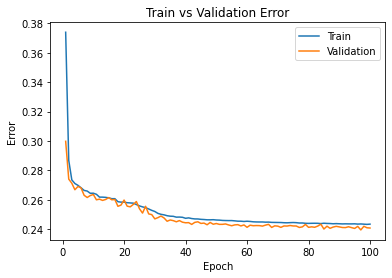

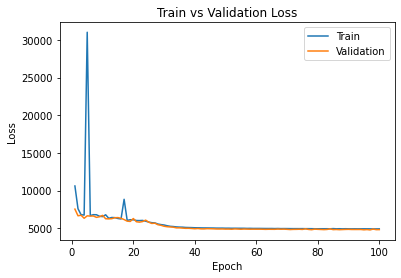

In [50]:
'''
More epochs
'''
# net = VAENetSmall("ASL_small", transfer_model=None, transfer_ftrs=1000)
net = CVAE(128)
net.name = "cvae"


batch = 1
lr = 0.0001
m = 0.9
epochs = 100

train_network(net, batch_size=batch, lr=lr, momentum=m, num_epochs=epochs, cuda=True)
model_path =  OUTPUT_DIR + get_model_name(net.name, batch, lr, m, epochs-1)
plot_training_curve(model_path)

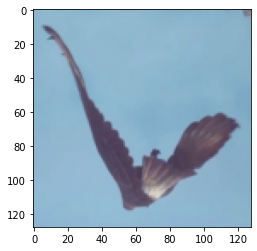

torch.Size([1, 3, 128, 128])


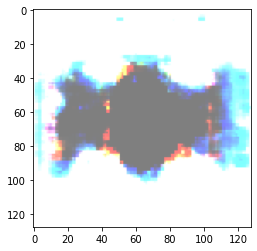

In [59]:
train_dl, val_dl, _ = get_data_loaders(batch_size=1)

net.eval()
net = net.to('cpu')
count = 0
for data in train_dl:
    count += 1
    if count < 1:
        continue
    img, _, _ = data
    imshow(img[0])
    
    out = net(img)
    out = out[0].detach()
    print(out.shape)
    imshow(out[0])
    print()
    
    break